In [2]:
%matplotlib inline


Model Selection using lmfit and emcee
=====================================

FIXME: this is a useful examples; however, it doesn't run correctly anymore as
the PTSampler was removed in emcee v3...


`lmfit.emcee` can be used to obtain the posterior probability distribution
of parameters, given a set of experimental data. This notebook shows how it
can be used for Bayesian model selection.



In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lmfit

Define a Gaussian lineshape and generate some data:



In [3]:
def gauss(x, a_max, loc, sd):
    return a_max * np.exp(-((x - loc) / sd)**2)


x = np.linspace(3, 7, 250)
np.random.seed(0)
y = 4 + 10 * x + gauss(x, 200, 5, 0.5) + gauss(x, 60, 5.8, 0.2)
dy = np.sqrt(y)
y += dy * np.random.randn(y.size)

Plot the data:



<ErrorbarContainer object of 3 artists>

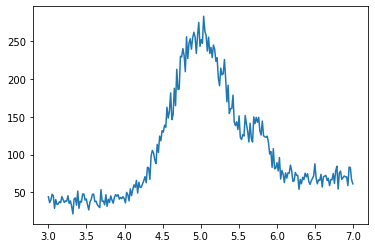

In [4]:
plt.errorbar(x, y)

Define the normalised residual for the data:



In [5]:
def residual(p, just_generative=False):
    v = p.valuesdict()
    generative = v['a'] + v['b'] * x
    M = 0
    while 'a_max%d' % M in v:
        generative += gauss(x, v['a_max%d' % M], v['loc%d' % M], v['sd%d' % M])
        M += 1

    if just_generative:
        return generative
    return (generative - y) / dy

Create a Parameter set for the initial guesses:



In [6]:
def initial_peak_params(M):
    p = lmfit.Parameters()

    # a and b give a linear background
    a = np.mean(y)
    b = 1

    # a_max, loc and sd are the amplitude, location and SD of each Gaussian
    # component
    a_max = np.max(y)
    loc = np.mean(x)
    sd = (np.max(x) - np.min(x)) * 0.5

    p.add_many(('a', a, True, 0, 10), ('b', b, True, 1, 15))

    for i in range(M):
        p.add_many(('a_max%d' % i, 0.5 * a_max, True, 10, a_max),
                   ('loc%d' % i, loc, True, np.min(x), np.max(x)),
                   ('sd%d' % i, sd, True, 0.1, np.max(x) - np.min(x)))
    return p

Solving with `minimize` gives the Maximum Likelihood solution.



In [7]:
p1 = initial_peak_params(1)
mi1 = lmfit.minimize(residual, p1, method='differential_evolution')

lmfit.printfuncs.report_fit(mi1.params, min_correl=0.5)

[[Variables]]
    a:       1.51255587 +/- 2.85249723 (188.59%) (init = 10)
    b:       10.5608538 +/- 0.60807955 (5.76%) (init = 1)
    a_max0:  193.129327 +/- 3.84004837 (1.99%) (init = 141.2683)
    loc0:    5.03878769 +/- 0.00822976 (0.16%) (init = 5)
    sd0:     0.57100576 +/- 0.01196125 (2.09%) (init = 2)
[[Correlations]] (unreported correlations are < 0.500)
    C(a, b)        = -0.943
    C(a_max0, sd0) = -0.509


From inspection of the data above we can tell that there is going to be more
than 1 Gaussian component, but how many are there? A Bayesian approach can
be used for this model selection problem. We can do this with `lmfit.emcee`,
which uses the `emcee` package to do a Markov Chain Monte Carlo sampling of
the posterior probability distribution. `lmfit.emcee` requires a function
that returns the log-posterior probability. The log-posterior probability is
a sum of the log-prior probability and log-likelihood functions.

The log-prior probability encodes information about what you already believe
about the system. `lmfit.emcee` assumes that this log-prior probability is
zero if all the parameters are within their bounds and `-np.inf` if any of
the parameters are outside their bounds. As such it's a uniform prior.

The log-likelihood function is given below. To use non-uniform priors then
should include these terms in `lnprob`. This is the log-likelihood
probability for the sampling.



In [8]:
def lnprob(p):
    resid = residual(p, just_generative=True)
    return -0.5 * np.sum(((resid - y) / dy)**2 + np.log(2 * np.pi * dy**2))

To start with we have to create the minimizers and *burn* them in. We create
4 different minimizers representing 0, 1, 2 or 3 Gaussian contributions. To
do the model selection we have to integrate the over the log-posterior
distribution to see which has the higher probability. This is done using the
`thermodynamic_integration_log_evidence` method of the `sampler` attribute
contained in the `lmfit.Minimizer` object.



In [9]:
# Work out the log-evidence for different numbers of peaks:
total_steps = 310
burn = 300
thin = 10
ntemps = 15
workers = 1  # the multiprocessing does not work with sphinx-gallery
log_evidence = []
res = []

# set up the Minimizers
for i in range(4):
    p0 = initial_peak_params(i)
    # you can't use lnprob as a userfcn with minimize because it needs to be
    # maximised
    mini = lmfit.Minimizer(residual, p0)
    out = mini.minimize(method='differential_evolution')
    res.append(out)

mini = []
# burn in the samplers
for i in range(4):
    # do the sampling
    mini.append(lmfit.Minimizer(lnprob, res[i].params))
    out = mini[i].emcee(steps=total_steps, ntemps=ntemps, workers=workers,
                        reuse_sampler=False, float_behavior='posterior',
                        progress=True)
    # get the evidence
    print(i, total_steps, mini[i].sampler.thermodynamic_integration_log_evidence())
    log_evidence.append(mini[i].sampler.thermodynamic_integration_log_evidence()[0])

/home/jordi/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/jordi/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


DeprecationWarning: 'ntemps' has no effect anymore, since the PTSampler was removed from emcee version 3.

Once we've burned in the samplers we have to do a collection run. We thin
out the MCMC chain to reduce autocorrelation between successive samples.



In [10]:
for j in range(6):
    total_steps += 100
    for i in range(4):
        # do the sampling
        res = mini[i].emcee(burn=burn, steps=100, thin=thin, ntemps=ntemps,
                            workers=workers, reuse_sampler=True, progress=False)
        # get the evidence
        print(i, total_steps, mini[i].sampler.thermodynamic_integration_log_evidence())
        log_evidence.append(mini[i].sampler.thermodynamic_integration_log_evidence()[0])


plt.plot(log_evidence[-4:])
plt.ylabel('Log-evidence')
plt.xlabel('number of peaks')

DeprecationWarning: 'ntemps' has no effect anymore, since the PTSampler was removed from emcee version 3.

The Bayes factor is related to the exponential of the difference between the
log-evidence values.  Thus, 0 peaks is not very likely compared to 1 peak.
But 1 peak is not as good as 2 peaks. 3 peaks is not that much better than 2
peaks.



In [11]:
r01 = np.exp(log_evidence[-4] - log_evidence[-3])
r12 = np.exp(log_evidence[-3] - log_evidence[-2])
r23 = np.exp(log_evidence[-2] - log_evidence[-1])

print(r01, r12, r23)

IndexError: list index out of range

These numbers tell us that zero peaks is 0 times as likely as one peak. Two
peaks is 7e49 times more likely than one peak. Three peaks is 1.1 times more
likely than two peaks. With this data one would say that two peaks is
sufficient. Caution has to be taken with these values. The log-priors for
this sampling are uniform but improper, i.e. they are not normalised properly.
Internally the lnprior probability is calculated as 0 if all parameters are
within their bounds and `-np.inf` if any parameter is outside the bounds.
The `lnprob` function defined above is the log-likelihood alone. Remember,
that the log-posterior probability is equal to the sum of the log-prior and
log-likelihood probabilities. Extra terms can be added to the lnprob function
to calculate the normalised log-probability. These terms would look something
like:

\begin{align}\log (\prod_i \frac{1}{max_i - min_i})\end{align}

where $max_i$ and $min_i$ are the upper and lower bounds for the
parameter, and the prior is a uniform distribution. Other types of prior are
possible. For example, you might expect the prior to be Gaussian.

